# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV



from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [1]:
from data.process_data import clean_data

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\polys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\polys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\polys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
db_path=r'data/DisasterResponse.db'

In [3]:
# load data from database
engine = create_engine(f'sqlite:///{db_path}')

In [4]:
engine

Engine(sqlite:///data/DisasterResponse.db)

In [5]:
df = pd.read_sql("SELECT * FROM DisasterResponse",engine)
df.index=df['id']
X = df[['message','original','genre']]
y = df.drop(columns=['id','message','original','genre'])

In [6]:
df[df.columns[4:]]['related'].value_counts()

1    20093
0     6122
Name: related, dtype: int64

In [7]:
categories=list(y.columns)
categories

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [8]:
X

,message,original,genre
id,,,
2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct
...,...,...,...
30261,The training demonstrated how to enhance micro...,None,news
30262,A suitable candidate has been selected and OCH...,None,news
30263,"Proshika, operating in Cox's Bazar municipalit...",None,news


In [9]:
y

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
id,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30263,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [10]:
def tokenize(text):
    #lower case and add remove punctuation
    text=re.sub(r"[^a-zA-Z0-9]"," ",text.lower())
    
    #tokenize text
    tokens=word_tokenize(text)
    
    #remove stop words and lemmatize
    tokens = [WordNetLemmatizer().lemmatize(w)  for w in tokens if w not in stopwords.words("english")]
    
    return tokens
        

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [11]:
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(lgb.LGBMClassifier()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [12]:
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
y_train.shape,X_train.shape

((19661, 36), (19661, 3))

In [14]:
pipeline.fit(X_train['message'],y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x0000023F76162700>)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(estimator=LGBMClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [15]:
y_pred=pipeline.predict(X_test['message'])

In [17]:
len(y_pred[:,1])

6554

In [16]:
y_test.iloc[:,1].name

'request'

In [17]:
for i in range(y_pred.shape[1]):
    
    y_true_col=y_test.iloc[:,i]
    y_pred_col=y_pred[:,i]
    
    category=y_true_col.name
    print("#"*60)
    print(f"Classification report for category: {category}\n")
    print(classification_report(y_true_col, y_pred_col))

############################################################
Classification report for category: related

              precision    recall  f1-score   support

           0       0.71      0.46      0.56      1490
           1       0.86      0.94      0.90      5064

    accuracy                           0.84      6554
   macro avg       0.78      0.70      0.73      6554
weighted avg       0.82      0.84      0.82      6554

############################################################
Classification report for category: request

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5443
           1       0.80      0.59      0.68      1111

    accuracy                           0.91      6554
   macro avg       0.86      0.78      0.81      6554
weighted avg       0.90      0.91      0.90      6554

############################################################
Classification report for category: offer

              precision    rec

C:\Users\polys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\polys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\polys\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 6. Improve your model
Use grid search to find better parameters. 

In [18]:
pipeline['clf'].get_params()

{'estimator__boosting_type': 'gbdt',
 'estimator__class_weight': None,
 'estimator__colsample_bytree': 1.0,
 'estimator__importance_type': 'split',
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': -1,
 'estimator__min_child_samples': 20,
 'estimator__min_child_weight': 0.001,
 'estimator__min_split_gain': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': -1,
 'estimator__num_leaves': 31,
 'estimator__objective': None,
 'estimator__random_state': None,
 'estimator__reg_alpha': 0.0,
 'estimator__reg_lambda': 0.0,
 'estimator__silent': 'warn',
 'estimator__subsample': 1.0,
 'estimator__subsample_for_bin': 200000,
 'estimator__subsample_freq': 0,
 'estimator': LGBMClassifier(),
 'n_jobs': None}

In [19]:
parameters = {
        #'vect__ngram_range': ((1, 1), (1, 2)),
        #'vect__max_df': (0.5, 0.75, 1.0),
        #'vect__max_features': (None, 5000, 10000),
        'tfidf__use_idf': (True, False),
        #'estimator__n_estimators': [50, 100, 200],
        #'clf__estimator__min_samples_split': [2, 3, 4],
        'clf__estimator__max_depth':[10,None]
      
    }

cv = GridSearchCV(pipeline,param_grid=parameters,cv=3,verbose=10)

In [20]:
cv.fit(X_train['message'],y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START clf__estimator__max_depth=10, tfidf__use_idf=True...........
[CV 1/3; 1/4] END clf__estimator__max_depth=10, tfidf__use_idf=True; total time= 2.0min
[CV 2/3; 1/4] START clf__estimator__max_depth=10, tfidf__use_idf=True...........
[CV 2/3; 1/4] END clf__estimator__max_depth=10, tfidf__use_idf=True; total time= 2.0min
[CV 3/3; 1/4] START clf__estimator__max_depth=10, tfidf__use_idf=True...........
[CV 3/3; 1/4] END clf__estimator__max_depth=10, tfidf__use_idf=True; total time= 2.0min
[CV 1/3; 2/4] START clf__estimator__max_depth=10, tfidf__use_idf=False..........
[CV 1/3; 2/4] END clf__estimator__max_depth=10, tfidf__use_idf=False; total time= 2.0min
[CV 2/3; 2/4] START clf__estimator__max_depth=10, tfidf__use_idf=False..........
[CV 2/3; 2/4] END clf__estimator__max_depth=10, tfidf__use_idf=False; total time= 2.0min
[CV 3/3; 2/4] START clf__estimator__max_depth=10, tfidf__use_idf=False..........
[CV 3/3; 2/4

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x0000023F76162700>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=LGBMClassifier()))]),
             param_grid={'clf__estimator__max_depth': [10, None],
                         'tfidf__use_idf': (True, False)},
             verbose=10)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [21]:
y_pred = cv.predict(X_test['message'])

In [22]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

Confusio nMatrix:
############################################################
Classification report for category: related
              precision    recall  f1-score   support

           0       0.71      0.47      0.56      1490
           1       0.86      0.94      0.90      5064

    accuracy                           0.84      6554
   macro avg       0.78      0.70      0.73      6554
weighted avg       0.82      0.84      0.82      6554

Confusion Matrix for category: related



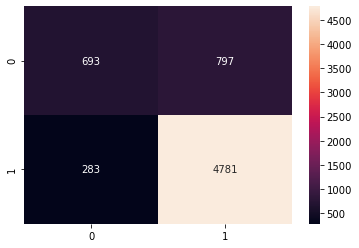

############################################################
Classification report for category: request
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5443
           1       0.81      0.59      0.68      1111

    accuracy                           0.91      6554
   macro avg       0.87      0.78      0.81      6554
weighted avg       0.90      0.91      0.90      6554

Confusion Matrix for category: request



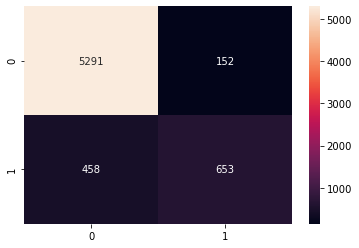

############################################################
Classification report for category: offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6522
           1       0.00      0.00      0.00        32

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      6554

Confusion Matrix for category: offer



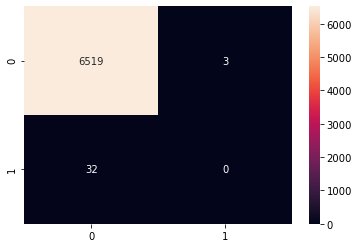

############################################################
Classification report for category: aid_related
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3791
           1       0.76      0.71      0.74      2763

    accuracy                           0.79      6554
   macro avg       0.78      0.78      0.78      6554
weighted avg       0.78      0.79      0.78      6554

Confusion Matrix for category: aid_related



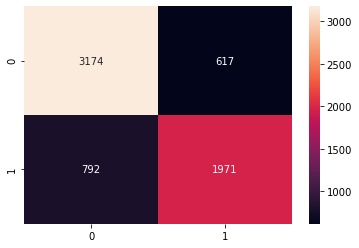

############################################################
Classification report for category: medical_help
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      6026
           1       0.55      0.29      0.38       528

    accuracy                           0.92      6554
   macro avg       0.74      0.64      0.67      6554
weighted avg       0.91      0.92      0.91      6554

Confusion Matrix for category: medical_help



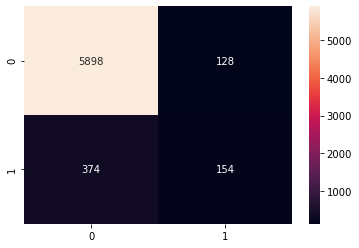

############################################################
Classification report for category: medical_products
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      6200
           1       0.70      0.34      0.46       354

    accuracy                           0.96      6554
   macro avg       0.83      0.66      0.72      6554
weighted avg       0.95      0.96      0.95      6554

Confusion Matrix for category: medical_products



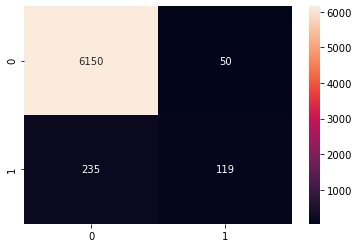

############################################################
Classification report for category: search_and_rescue
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6376
           1       0.69      0.20      0.31       178

    accuracy                           0.98      6554
   macro avg       0.83      0.60      0.65      6554
weighted avg       0.97      0.98      0.97      6554

Confusion Matrix for category: search_and_rescue



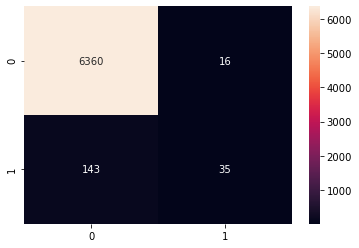

############################################################
Classification report for category: security
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6432
           1       0.17      0.01      0.02       122

    accuracy                           0.98      6554
   macro avg       0.57      0.50      0.50      6554
weighted avg       0.97      0.98      0.97      6554

Confusion Matrix for category: security



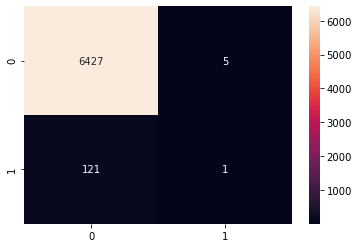

############################################################
Classification report for category: military
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6332
           1       0.57      0.36      0.45       222

    accuracy                           0.97      6554
   macro avg       0.78      0.68      0.72      6554
weighted avg       0.96      0.97      0.97      6554

Confusion Matrix for category: military



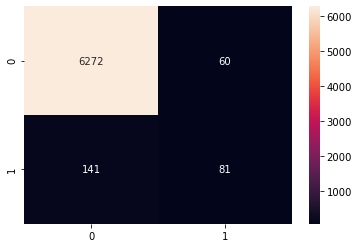

############################################################
Classification report for category: child_alone
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6554

    accuracy                           1.00      6554
   macro avg       1.00      1.00      1.00      6554
weighted avg       1.00      1.00      1.00      6554

Confusion Matrix for category: child_alone



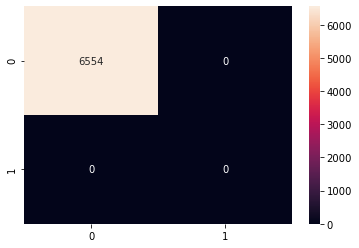

############################################################
Classification report for category: water
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6085
           1       0.80      0.65      0.72       469

    accuracy                           0.96      6554
   macro avg       0.89      0.82      0.85      6554
weighted avg       0.96      0.96      0.96      6554

Confusion Matrix for category: water



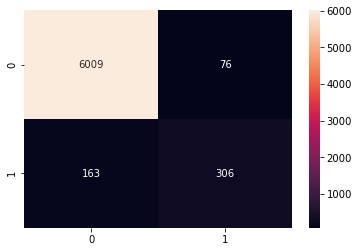

############################################################
Classification report for category: food
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5823
           1       0.79      0.79      0.79       731

    accuracy                           0.95      6554
   macro avg       0.88      0.88      0.88      6554
weighted avg       0.95      0.95      0.95      6554

Confusion Matrix for category: food



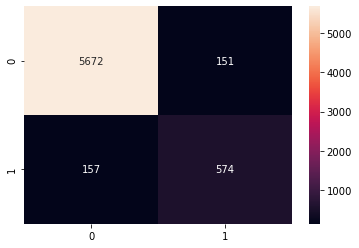

############################################################
Classification report for category: shelter
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5962
           1       0.75      0.61      0.68       592

    accuracy                           0.95      6554
   macro avg       0.86      0.80      0.82      6554
weighted avg       0.94      0.95      0.94      6554

Confusion Matrix for category: shelter



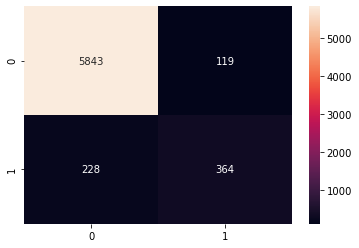

############################################################
Classification report for category: clothing
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6448
           1       0.78      0.42      0.55       106

    accuracy                           0.99      6554
   macro avg       0.88      0.71      0.77      6554
weighted avg       0.99      0.99      0.99      6554

Confusion Matrix for category: clothing



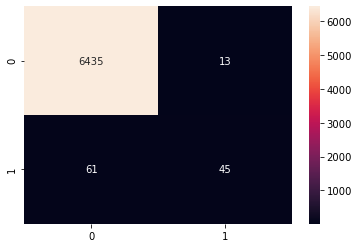

############################################################
Classification report for category: money
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6408
           1       0.60      0.24      0.34       146

    accuracy                           0.98      6554
   macro avg       0.79      0.62      0.67      6554
weighted avg       0.97      0.98      0.98      6554

Confusion Matrix for category: money



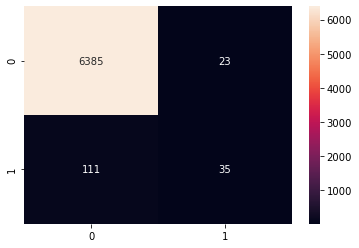

############################################################
Classification report for category: missing_people
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6482
           1       0.64      0.29      0.40        72

    accuracy                           0.99      6554
   macro avg       0.81      0.64      0.70      6554
weighted avg       0.99      0.99      0.99      6554

Confusion Matrix for category: missing_people



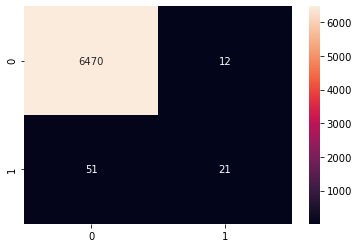

############################################################
Classification report for category: refugees
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      6319
           1       0.64      0.23      0.34       235

    accuracy                           0.97      6554
   macro avg       0.81      0.61      0.66      6554
weighted avg       0.96      0.97      0.96      6554

Confusion Matrix for category: refugees



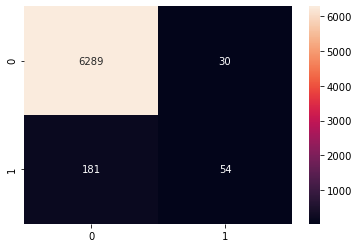

############################################################
Classification report for category: death
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      6259
           1       0.72      0.55      0.63       295

    accuracy                           0.97      6554
   macro avg       0.85      0.77      0.81      6554
weighted avg       0.97      0.97      0.97      6554

Confusion Matrix for category: death



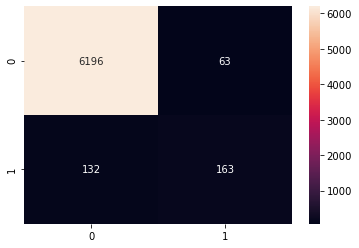

############################################################
Classification report for category: other_aid
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      5671
           1       0.61      0.16      0.26       883

    accuracy                           0.87      6554
   macro avg       0.75      0.57      0.59      6554
weighted avg       0.85      0.87      0.84      6554

Confusion Matrix for category: other_aid



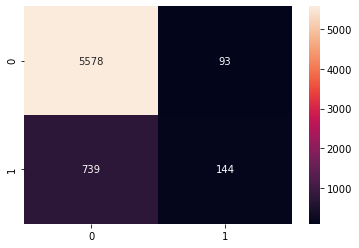

############################################################
Classification report for category: infrastructure_related
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6123
           1       0.53      0.06      0.10       431

    accuracy                           0.93      6554
   macro avg       0.74      0.53      0.53      6554
weighted avg       0.91      0.93      0.91      6554

Confusion Matrix for category: infrastructure_related



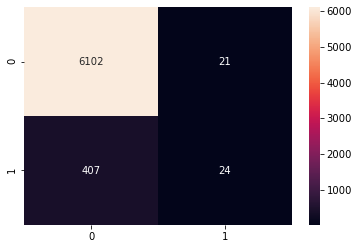

############################################################
Classification report for category: transport
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6252
           1       0.74      0.24      0.36       302

    accuracy                           0.96      6554
   macro avg       0.85      0.62      0.67      6554
weighted avg       0.95      0.96      0.95      6554

Confusion Matrix for category: transport



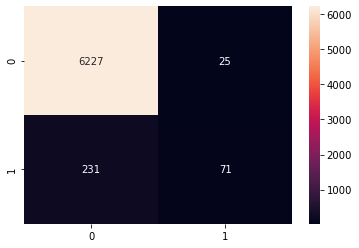

############################################################
Classification report for category: buildings
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6238
           1       0.76      0.40      0.53       316

    accuracy                           0.97      6554
   macro avg       0.87      0.70      0.75      6554
weighted avg       0.96      0.97      0.96      6554

Confusion Matrix for category: buildings



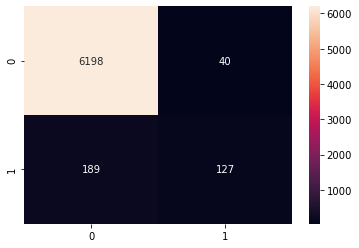

############################################################
Classification report for category: electricity
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6417
           1       0.53      0.30      0.38       137

    accuracy                           0.98      6554
   macro avg       0.76      0.65      0.69      6554
weighted avg       0.98      0.98      0.98      6554

Confusion Matrix for category: electricity



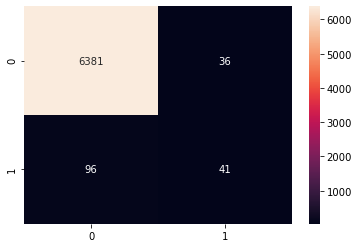

############################################################
Classification report for category: tools
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6509
           1       0.00      0.00      0.00        45

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      6554

Confusion Matrix for category: tools



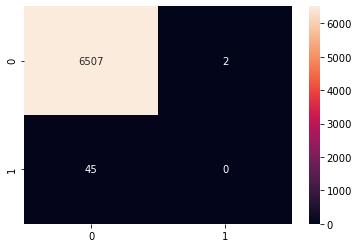

############################################################
Classification report for category: hospitals
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6483
           1       0.40      0.08      0.14        71

    accuracy                           0.99      6554
   macro avg       0.70      0.54      0.57      6554
weighted avg       0.98      0.99      0.99      6554

Confusion Matrix for category: hospitals



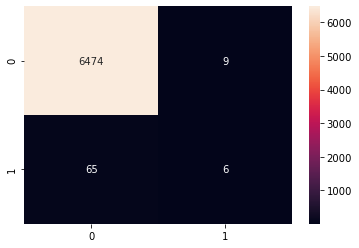

############################################################
Classification report for category: shops
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6523
           1       0.00      0.00      0.00        31

    accuracy                           0.99      6554
   macro avg       0.50      0.50      0.50      6554
weighted avg       0.99      0.99      0.99      6554

Confusion Matrix for category: shops



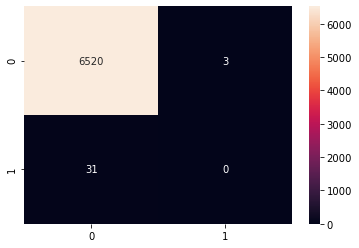

############################################################
Classification report for category: aid_centers
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6464
           1       0.60      0.07      0.12        90

    accuracy                           0.99      6554
   macro avg       0.79      0.53      0.56      6554
weighted avg       0.98      0.99      0.98      6554

Confusion Matrix for category: aid_centers



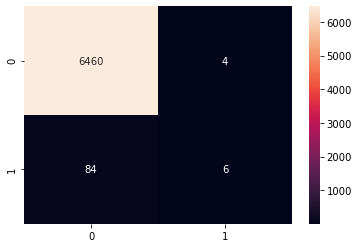

############################################################
Classification report for category: other_infrastructure
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6264
           1       0.43      0.04      0.08       290

    accuracy                           0.96      6554
   macro avg       0.69      0.52      0.53      6554
weighted avg       0.93      0.96      0.94      6554

Confusion Matrix for category: other_infrastructure



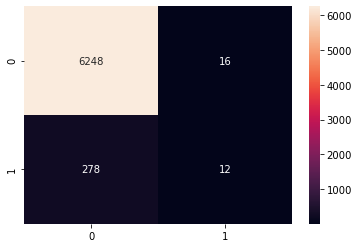

############################################################
Classification report for category: weather_related
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      4733
           1       0.84      0.76      0.80      1821

    accuracy                           0.89      6554
   macro avg       0.88      0.85      0.86      6554
weighted avg       0.89      0.89      0.89      6554

Confusion Matrix for category: weather_related



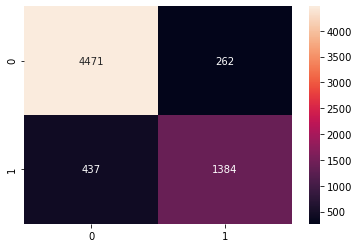

############################################################
Classification report for category: floods
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6008
           1       0.85      0.61      0.71       546

    accuracy                           0.96      6554
   macro avg       0.91      0.80      0.84      6554
weighted avg       0.96      0.96      0.96      6554

Confusion Matrix for category: floods



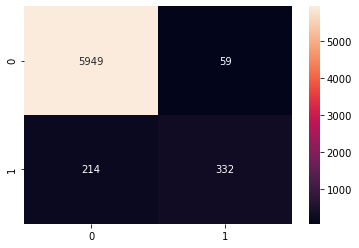

############################################################
Classification report for category: storm
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5934
           1       0.74      0.70      0.72       620

    accuracy                           0.95      6554
   macro avg       0.86      0.84      0.85      6554
weighted avg       0.95      0.95      0.95      6554

Confusion Matrix for category: storm



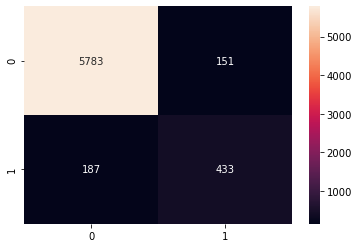

############################################################
Classification report for category: fire
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      6498
           1       0.55      0.29      0.38        56

    accuracy                           0.99      6554
   macro avg       0.77      0.64      0.69      6554
weighted avg       0.99      0.99      0.99      6554

Confusion Matrix for category: fire



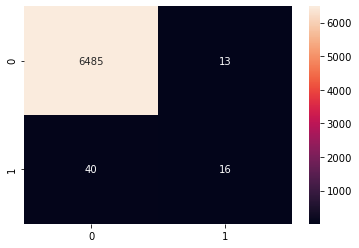

############################################################
Classification report for category: earthquake
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5950
           1       0.88      0.83      0.85       604

    accuracy                           0.97      6554
   macro avg       0.93      0.91      0.92      6554
weighted avg       0.97      0.97      0.97      6554

Confusion Matrix for category: earthquake



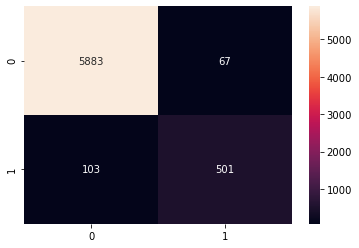

############################################################
Classification report for category: cold
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6425
           1       0.64      0.34      0.44       129

    accuracy                           0.98      6554
   macro avg       0.81      0.67      0.72      6554
weighted avg       0.98      0.98      0.98      6554

Confusion Matrix for category: cold



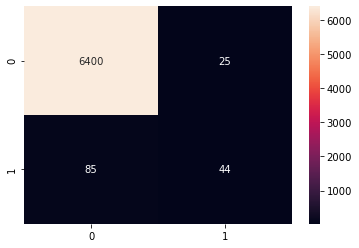

############################################################
Classification report for category: other_weather
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6220
           1       0.52      0.13      0.21       334

    accuracy                           0.95      6554
   macro avg       0.74      0.56      0.59      6554
weighted avg       0.93      0.95      0.94      6554

Confusion Matrix for category: other_weather



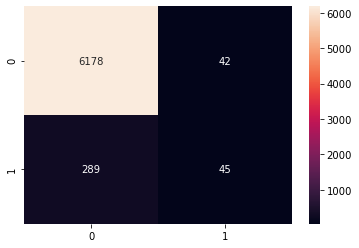

############################################################
Classification report for category: direct_report
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      5301
           1       0.74      0.49      0.59      1253

    accuracy                           0.87      6554
   macro avg       0.81      0.72      0.75      6554
weighted avg       0.86      0.87      0.86      6554

Confusion Matrix for category: direct_report



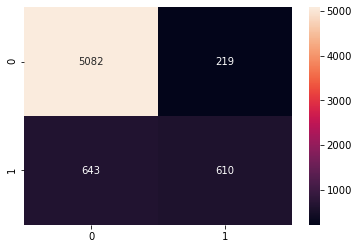

Accuracy: related                   0.835215
request                   0.906927
offer                     0.994660
aid_related               0.785017
medical_help              0.923406
medical_products          0.956515
search_and_rescue         0.975740
security                  0.980775
military                  0.969332
child_alone               1.000000
water                     0.963534
food                      0.953006
shelter                   0.947055
clothing                  0.988709
money                     0.979554
missing_people            0.990388
refugees                  0.967806
death                     0.970247
other_aid                 0.873055
infrastructure_related    0.934696
transport                 0.960940
buildings                 0.965060
electricity               0.979860
tools                     0.992829
hospitals                 0.988709
shops                     0.994812
aid_centers               0.986573
other_infrastructure      0.955142
weather_re

In [36]:
confusion_mat = multilabel_confusion_matrix(y_test, y_pred)
accuracy = (y_pred == y_test).mean()

#print("Labels:", labels)
print("Confusio nMatrix:")
for i,mat in enumerate(confusion_mat):
    print("#"*60)
    print(f"Classification report for category: { categories[i]}")
    print(classification_report(y_test.iloc[:,i], y_pred[:,i]))
    print(f"Confusion Matrix for category: {categories[i]}\n")
    sns.heatmap(mat,annot=True,fmt='g')
    plt.show()

print("Accuracy:", accuracy)
print("\nBest Parameters:", cv.best_params_)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [37]:
filename = 'disaster_model.sav'
pickle.dump(cv, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.